# 🔁 LSTM vs GRU - Redes Recorrentes Avançadas

## Introdução
Tanto LSTM (Long Short-Term Memory) quanto GRU (Gated Recurrent Unit) são variantes das Redes Neurais Recorrentes (RNNs), projetadas para resolver o problema do desvanecimento do gradiente e capturar dependências de longo prazo em sequências.

<img src="https://miro.medium.com/v2/resize:fit:850/1*AeKfV2uAPeMg9j8HhQZk2w.png">

## LSTM - Long Short-Term Memory

### 🧠 Como funciona?
O LSTM introduz células de memória que podem preservar informações por longos períodos, controladas por portas:

* Porta de esquecimento `(f_t)`: decide o que esquecer da célula anterior.
* Porta de entrada `(i_t)`: decide o que armazenar da entrada atual.
* Porta de saída `(o_t)`: decide o que enviar para a próxima etapa.

### ✅ Vantagens
* Excelente para aprender dependências de longo prazo
* Muito usado em modelos de linguagem, previsão de séries temporais, tradução automática

### ❌ Desvantagens
* Mais lento que GRU devido à complexidade (mais portas)
* Mais parâmetros → risco maior de overfitting com pouco dado

### 🧠 LSTM - Entendendo o Mecanismo de Delay



#### Visão geral

A LSTM é uma arquitetura que retém memórias antigas (delay) e aprende quando esquecer ou lembrar dessas memórias ao longo do tempo. Isso é feito por meio de um estado de célula C_t que "carrega" a memória, como um fluxo controlado por portas lógicas.

#### Mecanismo de Delay (Memória)

A LSTM possui um mecanismo interno que permite reter informações por longos períodos, conhecido como **delay controlado**. Esse mecanismo é baseado em **portas** e no **estado de célula** que transporta a memória ao longo do tempo.

---

#### Como o delay (memória) funciona?

O "delay" na LSTM está embutido na maneira como ela:

##### 1. **Filtra o passado (Forget gate `f_t`)**
- Decide **quanto da memória anterior `C_{t-1}` manter**.
- Exemplo: se `f_t ≈ 1`, ela **mantém tudo**. Se `f_t ≈ 0`, **esquece**.

##### 2. **Seleciona o que lembrar (Input gate `i_t`)**
- Decide **quanto da nova informação** será **adicionada** à memória.
- Combinado com `~C_t`, que gera **novas ideias** com base em `x_t` e `h_{t-1}`.

##### 3. **Atualiza o estado da célula `C_t`**
- Combina o que foi **esquecido** e o que foi **aprendido**:

\begin{align}
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
\end{align}

- Isso representa o delay controlado: ela mantém informações úteis de etapas anteriores, e as libera somente quando necessário.

##### 4. Decide o que mostrar (Output gate `o_t`)
- Decide quanto da célula `C_t` será enviado como saída `h_t`.

- Controla o quanto da "memória" transparece para a próxima camada ou predição.

## GRU - Gated Recurrent Unit

### 🧠 Como funciona?
* O GRU simplifica o LSTM combinando algumas portas:
* Porta de atualização `(z_t)`: controla quanto do estado anterior manter
* Porta de reset `(r_t)`: decide quanto esquecer do passado ao computar o novo

### ✅ Vantagens
* Mais rápido que LSTM (menos portas)
* Menos parâmetros → mais eficiente em datasets menores

### ❌ Desvantagens
* Em alguns problemas, pode ter menor capacidade de modelar dependências longas comparado ao LSTM

# Previsão de Séries Temporais Financeiras com LSTM e GRU (PyTorch)

Este notebook mostra como usar redes LSTM com PyTorch para prever preços de ações usando dados financeiros abertos.

## Etapas
- Coletar dados do Yahoo Finance
- Pré-processar os dados
- Criar Dataset e DataLoader
- Definir modelo LSTM
- Treinar e avaliar

In [ ]:
!pip install yfinance matplotlib scikit-learn torch --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## ℹ️ Explicação dos Indicadores Técnicos

### 📊 1. Média Móvel Simples (SMA – Simple Moving Average)
**O que é:**  
A SMA é a média aritmética dos preços de fechamento de um ativo durante um determinado número de períodos.

**Fórmula:**  
\begin{align}
{SMA}_n = \frac{P_1 + P_2 + \dots + P_n}{n}
\end{align}

**Para que serve:**  
- Suaviza a série temporal de preços, facilitando a identificação de tendências  
- Muito usada para cruzamentos (ex: SMA curta cruzando SMA longa)

---

### 📈 2. Média Móvel Exponencial (EMA – Exponential Moving Average)
**O que é:**  
A EMA dá mais peso aos dados recentes, tornando-a mais sensível a mudanças recentes nos preços do que a SMA.

**Fórmula:**  
\begin{align}
{EMA}_t = \alpha \cdot P_t + (1 - \alpha) \cdot \text{EMA}_{t-1} \quad \text{onde } \alpha = \frac{2}{n+1}
\end{align}

**Para que serve:**  
- Reage mais rápido a mudanças de preço recentes  
- Ideal para capturar movimentos mais curtos

---

### 🔄 3. Índice de Força Relativa (RSI – Relative Strength Index)
**O que é:**  
É um oscilador que mede a velocidade e a mudança dos movimentos de preço, indicando se um ativo está sobrecomprado ou sobrevendido.

**Fórmula simplificada:**  
\begin{align}
{RSI} = 100 - \frac{100}{1 + RS} \quad \text{onde } RS = \frac{\text{Ganho médio}}{\text{Perda média}}
\end{align}

**Interpretação típica:**  
- RSI > 70 → sobrecomprado  
- RSI < 30 → sobrevendido

---

### ✅ Comparação rápida:

| Indicador | Tipo       | Sensível a mudanças recentes? | Ideal para...                      |
|-----------|------------|-------------------------------|------------------------------------|
| SMA       | Tendência  | ❌ Não                         | Visão suave da tendência           |
| EMA       | Tendência  | ✅ Sim                         | Capturar mudanças recentes         |
| RSI       | Oscilador  | ✅ Sim                         | Identificar pontos de reversão     |

In [ ]:
# Função com pandas puro para calcular indicadores
def add_indicators(df, col='Close', window=14):
    df[f'SMA_{window}'] = df[col].rolling(window=window).mean()
    df[f'EMA_{window}'] = df[col].ewm(span=window, adjust=False).mean()
    delta = df[col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

## Coletando múltiplos ativos e extraindo indicadores técnicos

Vamos buscar os dados de fechamento ajustado e adicionar indicadores como:
- Média Móvel Simples (SMA)
- Média Móvel Exponencial (EMA)
- Índice de Força Relativa (RSI)

In [ ]:
# Coleta e preparação dos dados com indicadores
# 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA'
tickers = ['VALE3.SA']
dfs = []

for t in tickers:
    df = yf.download(t, start='2019-01-01', end='2025-07-31')
    df = df[['Close']].rename(columns={'Close': f'{t}_Close'})
    df = add_indicators(df, col=f'{t}_Close', window=14)
    dfs.append(df)

data = pd.concat(dfs, axis=1).dropna()
data.tail()

/tmp/ipython-input-3180643252.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start='2019-01-01', end='2025-07-31')
[*********************100%***********************]  1 of 1 completed


Price,VALE3.SA_Close,SMA_14,EMA_14,RSI_14
Ticker,VALE3.SA,,,
Date,,,,
2025-07-24,54.613594,53.433574,53.552750,56.425114
2025-07-25,53.811733,53.523973,53.587281,56.316294
2025-07-28,53.290039,53.563997,53.547649,52.705219
2025-07-29,52.961563,53.617822,53.469504,53.707210
2025-07-30,52.014786,53.518452,53.275542,42.982472


## Criando sequências multivariadas para entrada na LSTM

Convertendo os dados normalizados em sequências do tipo `[n_passo, n_features]`.
## 🧠 Entendendo a estrutura `[n_passos, n_features]`

Ao trabalhar com redes neurais recorrentes (como LSTM ou GRU), os dados de entrada precisam ser organizados em **sequências temporais**, com a seguinte estrutura:

\begin{align}
\texttt{[n_passos, n_features]}
\end{align}

---

### 📌 O que significa cada dimensão?

| Dimensão     | Significado                                                                 |
|--------------|------------------------------------------------------------------------------|
| `n_passos`   | Número de passos no tempo (ex: quantos dias passados a rede verá de uma vez) |
| `n_features` | Quantidade de variáveis disponíveis em cada passo (ex: Close, RSI, EMA etc)  |

---

### 🔁 Exemplo prático:

Imagine que você quer prever o preço de uma ação usando:
- os últimos **60 dias** (`n_passos = 60`)
- e 3 variáveis por dia: `Close`, `RSI`, `SMA` (`n_features = 3`)

Então, uma única entrada (amostra) terá shape:

\begin{align}
\texttt{[60, 3]}
\end{align}

---

### 🧪 No treino do modelo...

Você terá **muitas amostras**, cada uma com essa estrutura.  
O modelo espera os dados assim:

\begin{align}
\texttt{(n_amostras, n_passos, n_features)}
\end{align}

| Dimensão       | Exemplo prático             |
|----------------|-----------------------------|
| `n_amostras`   | 5000 janelas temporais      |
| `n_passos`     | 60 dias                     |
| `n_features`   | 3 variáveis por dia         |

---

### 🎯 Importância

- Essa estrutura preserva **a ordem temporal dos dados**
- Permite que o modelo **aprenda padrões no tempo**
- Garantir esse formato correto é **essencial para o LSTM funcionar**

---

Se estiver usando `PyTorch`, a entrada para o modelo deve ter shape:

```python
(batch_size, seq_len, input_size)
```

Ou seja:

```python
X.shape = (5000, 60, 3)
```

Se a dimensão estiver errada, o modelo não aprende corretamente ou lança erro de shape.

In [ ]:
# Normalizando os dados multivariados
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

### 🧠 O que acontecerá aqui:

Na função que prepara os dados para a LSTM, temos:

```python
data[i-seq_len:i]
```
* Isso gera uma janela temporal de n_passos linhas (ex: 60 dias).
* Cada linha contém n_features colunas (ex: Close, RSI, EMA, etc).
* Assim, estamos construindo uma sequência temporal multivariada.

Portanto, o resultado de X tem o formato final:

\begin{align}
X.shape=(\text{n_amostras}, \text{n_passos}, \text{n_features})
\end{align}

Exemplo:

```python
X.shape = (4600, 60, 12)
```

* 4600 amostras
* Cada uma olhando para 60 dias no passado
* Cada dia com 12 variáveis diferentes

In [ ]:
def create_multivariate_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # prever o fechamento do primeiro ativo
    return np.array(X), np.array(y)

In [ ]:
seq_len = 60
X, y = create_multivariate_sequences(scaled, seq_len)

# Divisão treino/teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Coleta e pré-processamento dos dados

## Dataset e DataLoader

### 🧠 Explicação: Classe `TimeSeriesDataset` e DataLoader

Este trecho cria um dataset personalizado para séries temporais e o integra com o `DataLoader` do PyTorch.

* Herda de torch.utils.data.Dataset
* Armazena as amostras $(X)$ e os rótulos $(y)$ como tensores PyTorch
* Permite indexar $(dataset[0])$ e iterar os dados em mini-lotes


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

* Divide os dados em conjuntos de treino e teste
* DataLoader entrega os dados em mini-lotes ```(batch_size=32)```
* O embaralhamento ```(shuffle=True)``` melhora a generalização do modelo durante o treinamento

In [ ]:
train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

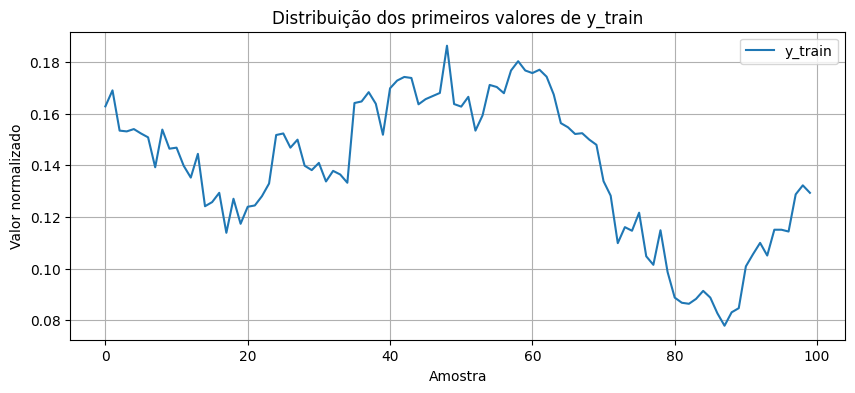

In [ ]:
# 🔍 Verificar se y_train tem variação significativa
plt.figure(figsize=(10, 4))
plt.plot(y_train[:100], label='y_train')
plt.title('Distribuição dos primeiros valores de y_train')
plt.xlabel('Amostra')
plt.ylabel('Valor normalizado')
plt.grid()
plt.legend()
plt.show()

## Definindo o modelo LSTM com GRU

Este modelo usa uma camada LSTM seguida de uma GRU para capturar padrões temporais em séries financeiras com múltiplas variáveis. A ideia é combinar o poder da **LSTM** para aprender dependências de longo prazo com a **eficiência da GRU**, que é mais leve e evita overfitting.

### 🧠 Diferenças entre LSTM e GRU

| Aspecto           | LSTM                                | GRU                                |
|-------------------|--------------------------------------|-------------------------------------|
| Células de memória| Sim (usa `c_t` e `h_t`)              | Não (apenas `h_t`)                  |
| Portas            | Input, Forget e Output               | Update e Reset                      |
| Complexidade      | Mais parâmetros                      | Menos parâmetros (mais leve)        |
| Treinamento       | Pode ser mais lento                  | Geralmente mais rápido              |
| Overfitting       | Maior risco                          | Menor risco                         |

---

### 📈 Quando usar esse modelo combinado?

- Quando há **muitos indicadores técnicos** (features)
- Quando o padrão da série varia muito em **curto e longo prazo**
- Quando o LSTM puro **não está convergindo bem**

Esse modelo fornece uma arquitetura **híbrida poderosa** e costuma funcionar bem com dados financeiros multivariados.


In [ ]:
class LSTM_GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_lstm=64, hidden_gru=32):
        super().__init__()

        # 🧠 LSTM: aprende padrões de longo prazo na série temporal
        # input_size: número de features por time step (ex: Close, RSI, EMA...)
        # hidden_lstm: número de neurônios na camada LSTM
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_lstm, batch_first=True)
        # self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)

        # 🔁 GRU: refina as representações aprendidas pela LSTM
        # Recebe como entrada a saída da LSTM
        self.gru = nn.GRU(input_size=hidden_lstm, hidden_size=hidden_gru, batch_first=True)

        # Camada densa final: transforma o hidden final da GRU em uma predição
        self.fc = nn.Linear(hidden_gru, 1)

    def forward(self, x):

        # LSTM layer
        out_lstm1, _ = self.lstm1(x)  # Shape: (batch, seq_len, hidden_lstm)
        # out_lstm2, _ = self.lstm2(x)  # Shape: (batch, seq_len, hidden_lstm)

        # GRU layer
        out_gru, _ = self.gru(out_lstm1)  # Shape: (batch, seq_len, hidden_gru)
        # out_gru, _ = self.gru(out_lstm2)  # Shape: (batch, seq_len, hidden_gru)

        # Pegamos apenas a última saída temporal
        final_output = self.fc(out_gru[:, -1, :])  # Shape: (batch, 1)

        return final_output


In [ ]:
# Detectar número de features automaticamente
input_size = X_train.shape[2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_GRU_Model(input_size=X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Treinamento do modelo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  1: Train Loss = 0.056709, Val Loss = 0.001346
Epoch  2: Train Loss = 0.004008, Val Loss = 0.001956
Epoch  3: Train Loss = 0.001777, Val Loss = 0.000758
Epoch  4: Train Loss = 0.001251, Val Loss = 0.000866
Epoch  5: Train Loss = 0.001250, Val Loss = 0.000789
Epoch  6: Train Loss = 0.001137, Val Loss = 0.000727
Epoch  7: Train Loss = 0.001137, Val Loss = 0.001064
Epoch  8: Train Loss = 0.001054, Val Loss = 0.000913
Epoch  9: Train Loss = 0.001009, Val Loss = 0.000756
Epoch 10: Train Loss = 0.001006, Val Loss = 0.000724
Epoch 11: Train Loss = 0.001016, Val Loss = 0.002702
Epoch 12: Train Loss = 0.001460, Val Loss = 0.000526
Epoch 13: Train Loss = 0.000844, Val Loss = 0.000982
Epoch 14: Train Loss = 0.000888, Val Loss = 0.000635
Epoch 15: Train Loss = 0.000792, Val Loss = 0.000576
Epoch 16: Train Loss = 0.000793, Val Loss = 0.000754
Epoch 17: Train Loss = 0.000875, Val Loss = 0.000877
Epoch 18: Train Loss = 0.000723, Val Loss = 0.000665
Epoch 19: Train Loss = 0.000702, Val Loss = 0.

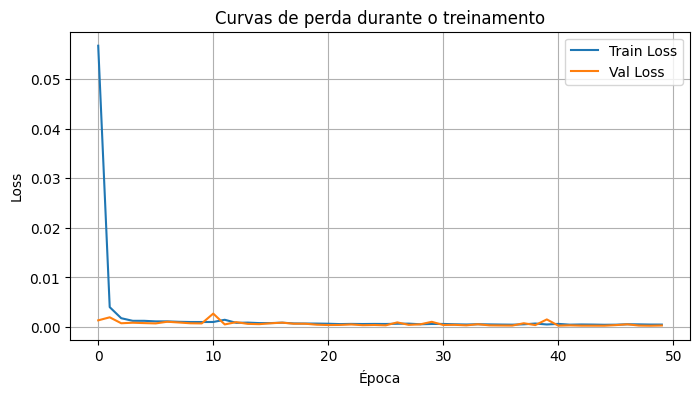

In [ ]:
# 🔁 Treinamento com validação por época + melhor modelo salvo
from copy import deepcopy
best_val_loss = float('inf')
best_model_state = None
train_losses, val_losses = [], []

for epoch in range(1, 51):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_loss = np.mean(batch_losses)

    # Validação
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze()
            val_loss = criterion(preds, yb)
            val_batch_losses.append(val_loss.item())
    val_loss = np.mean(val_batch_losses)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:2d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

    # Salvar melhor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())

# Restaurar melhor modelo após o treinamento
model.load_state_dict(best_model_state)

# Plot das curvas de perda
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Curvas de perda durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

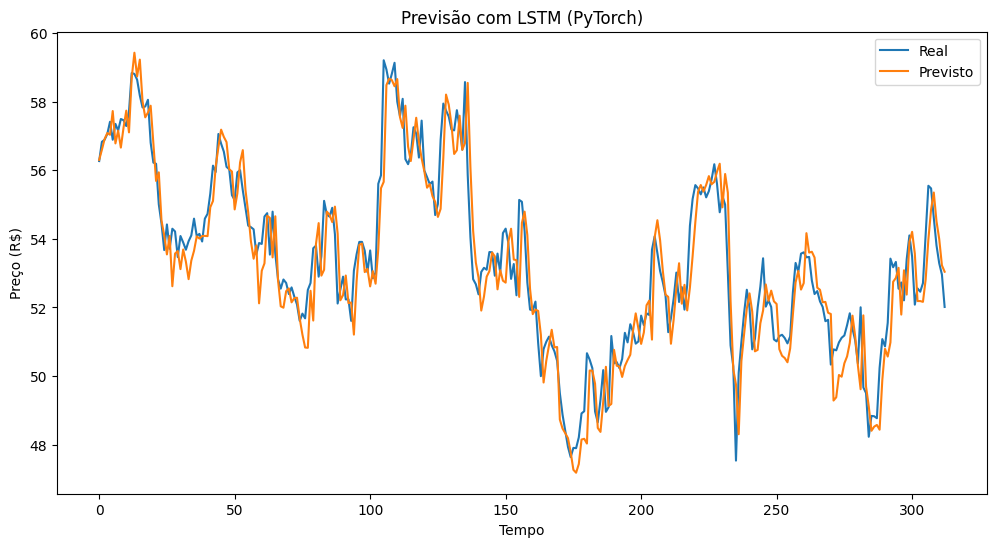

In [ ]:
# Avaliação com correção para scaler multivariado
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        preds.extend(out.cpu().numpy())

# Ajustar shape para inverse_transform apenas da feature alvo
preds = np.array(preds)
preds_full = np.zeros((len(preds), scaler.n_features_in_))
actual_full = np.zeros((len(y_test), scaler.n_features_in_))
preds_full[:, 0] = preds[:, 0]
actual_full[:, 0] = y_test

preds_inverse = scaler.inverse_transform(preds_full)[:, 0]
actual_inverse = scaler.inverse_transform(actual_full)[:, 0]

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual_inverse, label='Real')
plt.plot(preds_inverse, label='Previsto')
plt.legend()
plt.title('Previsão com LSTM (PyTorch)')
plt.xlabel('Tempo')
plt.ylabel('Preço (R$)')
plt.show()

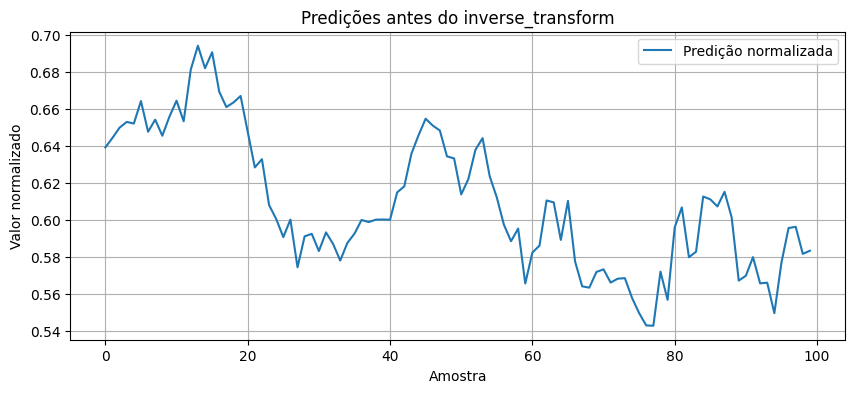

Predição (normalizada) - min: 0.4789, max: 0.6941, média: 0.5857


In [ ]:
# 🧪 Diagnóstico: distribuição das predições normalizadas
plt.figure(figsize=(10, 4))
plt.plot(preds[:100], label='Predição normalizada')
plt.title('Predições antes do inverse_transform')
plt.xlabel('Amostra')
plt.ylabel('Valor normalizado')
plt.grid()
plt.legend()
plt.show()

print(f"Predição (normalizada) - min: {preds.min():.4f}, max: {preds.max():.4f}, média: {preds.mean():.4f}")

## Avaliação e visualização

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


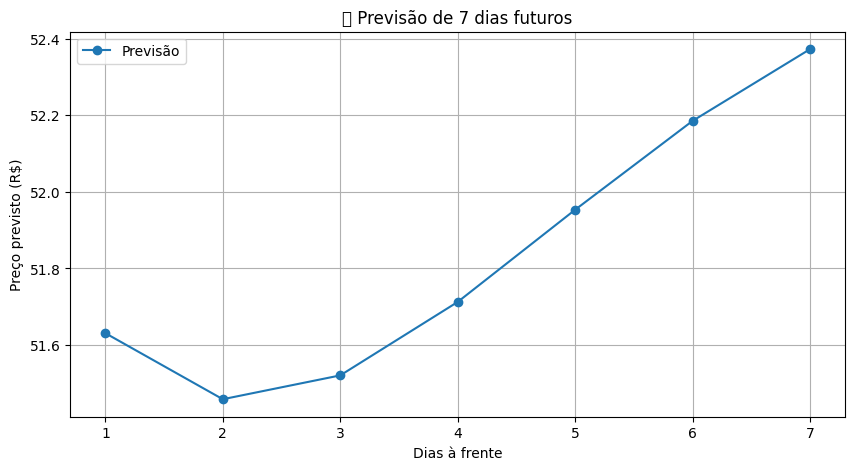

Dia +1: R$ 51.63
Dia +2: R$ 51.46
Dia +3: R$ 51.52
Dia +4: R$ 51.71
Dia +5: R$ 51.95
Dia +6: R$ 52.19
Dia +7: R$ 52.37


In [ ]:
# 🧠 Previsão de múltiplos dias à frente
model.eval()
n_future = 7  # número de dias a prever

# Última sequência disponível
last_sequence = data[-seq_len:].values
last_scaled = scaler.transform(last_sequence)
future_preds = []

# Preparar o primeiro input [1, seq_len, n_features]
current_input = torch.tensor(last_scaled, dtype=torch.float32).unsqueeze(0).to(device)

for _ in range(n_future):
    with torch.no_grad():
        next_pred = model(current_input)
        pred_val = next_pred.cpu().numpy()[0, 0]
        future_preds.append(pred_val)

    # Preparar próxima entrada
    # Manter todas as features da última linha, mas sobrescrever o target (índice 0)
    next_step = current_input[0, -1, :].cpu().numpy()
    next_step[0] = pred_val  # Substitui apenas o target
    next_step = next_step.reshape(1, -1)

    # Construir nova sequência deslocando uma posição à frente
    next_sequence = torch.cat([
        current_input[:, 1:, :],  # remove o primeiro dia
        torch.tensor(next_step, dtype=torch.float32).unsqueeze(0).to(device)  # adiciona novo dia
    ], dim=1)

    current_input = next_sequence

# Corrigir estrutura para inverse_transform
future_scaled_full = np.zeros((n_future, scaler.n_features_in_))
future_scaled_full[:, 0] = future_preds  # só preenche a coluna do target

# Inverte e extrai apenas o target original
future_prices = scaler.inverse_transform(future_scaled_full)[:, 0]

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(1, n_future + 1), future_prices, marker='o', label='Previsão')
plt.title('📅 Previsão de 7 dias futuros')
plt.xlabel('Dias à frente')
plt.ylabel('Preço previsto (R$)')
plt.grid()
plt.legend()
plt.show()

# Mostrar os valores
for i, p in enumerate(future_prices):
    print(f"Dia +{i+1}: R$ {p:.2f}")